# This notebook recreates plots in the results section of the paper

In [1]:
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import emcee
import corner
import scipy.stats as sps
from tqdm import trange
from isochrones.mist import MIST_Isochrone
mist = MIST_Isochrone()

from stardate.lhf import convective_overturn_time

Load the simulated data set.

In [3]:
df = pd.read_csv("data/simulated_data5.csv")
true_age_gyr = (10**df.age)*1e-9

Plot a corner plot for the first star.

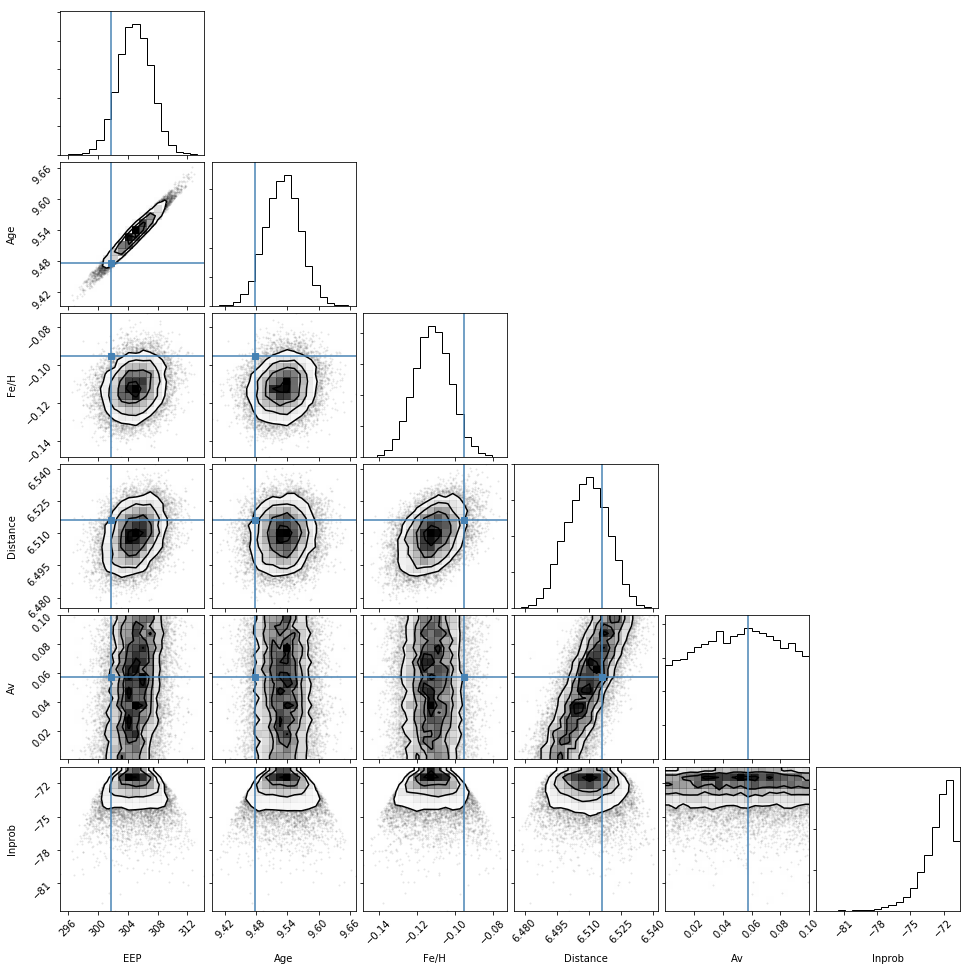

In [4]:
from stardate import load_samples

i = 0
fname = "simulation_results/{}_stardate_5_eep.h5".format(str(i).zfill(4))
flatsamples, samples = load_samples(fname, burnin=100)

truths = [df.eep.values[i], df.age.values[i], df.feh.values[i], np.log(1./(df.parallax[i]*1e-3)),
          df.Av.values[i], None]
labels = ["EEP", "Age", "Fe/H", "Distance", "Av", "lnprob"]
corner.corner(flatsamples, truths=truths, labels=labels);

### And plot the trace.

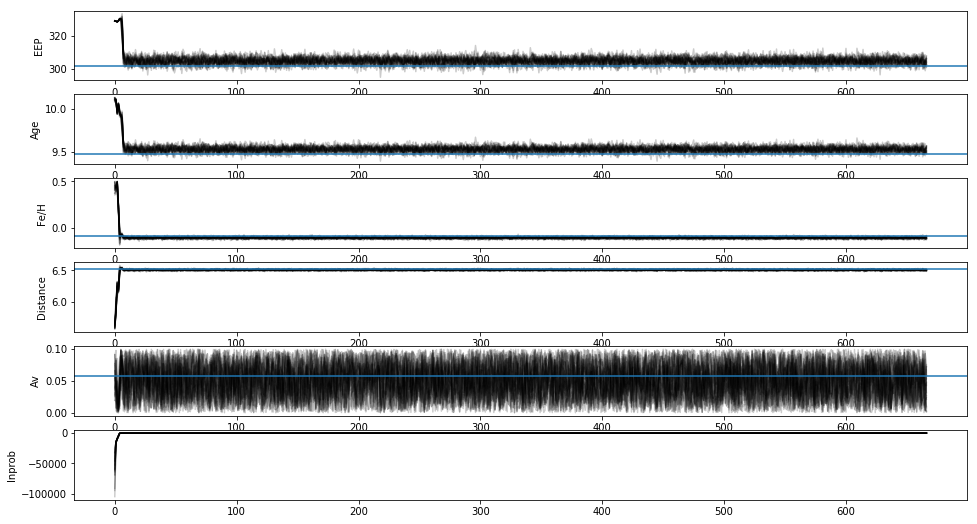

In [5]:
nsteps, nwalkers, ndim = np.shape(samples)
flat = np.reshape(samples, (nsteps*nwalkers, ndim))
plt.figure(figsize=(16, 9))
inits = []
for j in range(6):
    plt.subplot(6, 1, j+1)
    inits.append(samples[0, 0, j])
    plt.plot(samples[:, :, j], color="k", alpha=.2)
    plt.ylabel(labels[j])
    if truths[j] is not None:
        plt.axhline(truths[j])

And get the results for this star.

In [6]:
from stardate import read_samples

results = read_samples(flatsamples, burnin=0)  # Don't remove burn-in samples twice (did this in previous step)
results

,EEP_med,EEP_errm,EEP_errp,EEP_std,EEP_ml,age_med_gyr,age_errm,age_errp,age_std,age_ml_gyr,...,distance_errm,distance_errp,distance_std_pc,distance_ml,Av_med,Av_errm,Av_errp,Av_std,Av_ml,index
0,304.859614,2.173784,2.215611,2.204438,304.790202,3.401009,0.256453,0.259081,0.261634,3.380624,...,6.842283,6.496899,6.443504,671.296706,0.051467,0.0329,0.031798,0.027827,0.055414,0


Now load the results for all stars.

In [17]:
def read_files(name, ids, dirname=".", burnin=100, dynesty=False):
    meds, age_samps, errp, errm, ml, std, inds = [], [], [], [], [], [], []
    eeps, eep_errp, eep_errm, eep_std, eep_ml = [], [], [], [], []
    
    for i, ID in enumerate(ids):
        fname = "{0}/{1}_{2}.h5".format(dirname, str(int(ID)).zfill(4), name)
        
        try:
            flatsamples, samples = load_samples(fname, burnin=100)
            results = read_samples(flatsamples)
            
            meds.append(float(results.age_med_gyr))
            errp.append(float(results.age_errp[0]))
            errm.append(float(results.age_errm[0]))
            std.append(float(results.age_std[0]))
            ml.append(float(results.age_ml_gyr))
            inds.append(i)
                                
            eeps.append(float(results.EEP_med))
            eep_errp.append(float(results.EEP_errp))
            eep_errm.append(float(results.EEP_errm))
            eep_std.append(float(results.EEP_std))
            eep_ml.append(float(results.EEP_ml))  
                    
        except:
            pass
    
    return np.array(meds), np.array(errp), np.array(errm), np.array(std), np.array(ml),\
           np.array(eeps), np.array(eep_errp), np.array(eep_errm), np.array(eep_std), np.array(eep_ml),\
           np.array(inds)

meds, errp, errm, std, ml,eeps, eep_errp, eep_errm, eep_std, eep_ml, inds \
    = read_files("stardate_5_eep", np.arange(1000), dirname="simulation_results")

print(len(inds))

/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


310


Select stars of different types.

In [18]:
def selection(df, inds):

    bprp = df.BP.values[inds] - df.RP.values[inds]
    hot_cut, cool_cut, giant_cut, ro_cut = 0, 2.2, 420, 2
    Ro = (df.prot.values[inds]/convective_overturn_time(df.mass.values[inds]))
    evolved = (df.eep.values[inds] > giant_cut)
    hot = (bprp < hot_cut) * (df.eep.values[inds] < giant_cut)
    hot_evolved = (bprp < hot_cut) * (df.eep.values[inds] > giant_cut)
    cool = (bprp > cool_cut) * (df.eep.values[inds] < giant_cut) * (Ro < ro_cut)
    fgk = (df.eep.values[inds] < giant_cut) * (bprp > hot_cut) * (bprp < cool_cut) * (Ro < ro_cut)
    rossbied = (Ro >= ro_cut) * (bprp > hot_cut) * (bprp < cool_cut) * (df.eep.values[inds] < giant_cut)
        
    return fgk, hot, cool, evolved, rossbied

fgk, hot, cool, evolved, rossbied = selection(df, inds)

Now load isochrone-only posteriors.

In [20]:
imeds, ierrp, ierrm, istd, iml, ieeps, ieep_errp, ieep_errm, ieep_std, ieep_ml, iinds \
    = read_files("iso_err", np.arange(1000), dirname="simulation_results")
ifgk, ihot, icool, ievolved, irossbied = selection(df, iinds)
print(len(iinds))

93


Plot the empirical precision on the HR diagram (use log g to spread out the main sequence better).

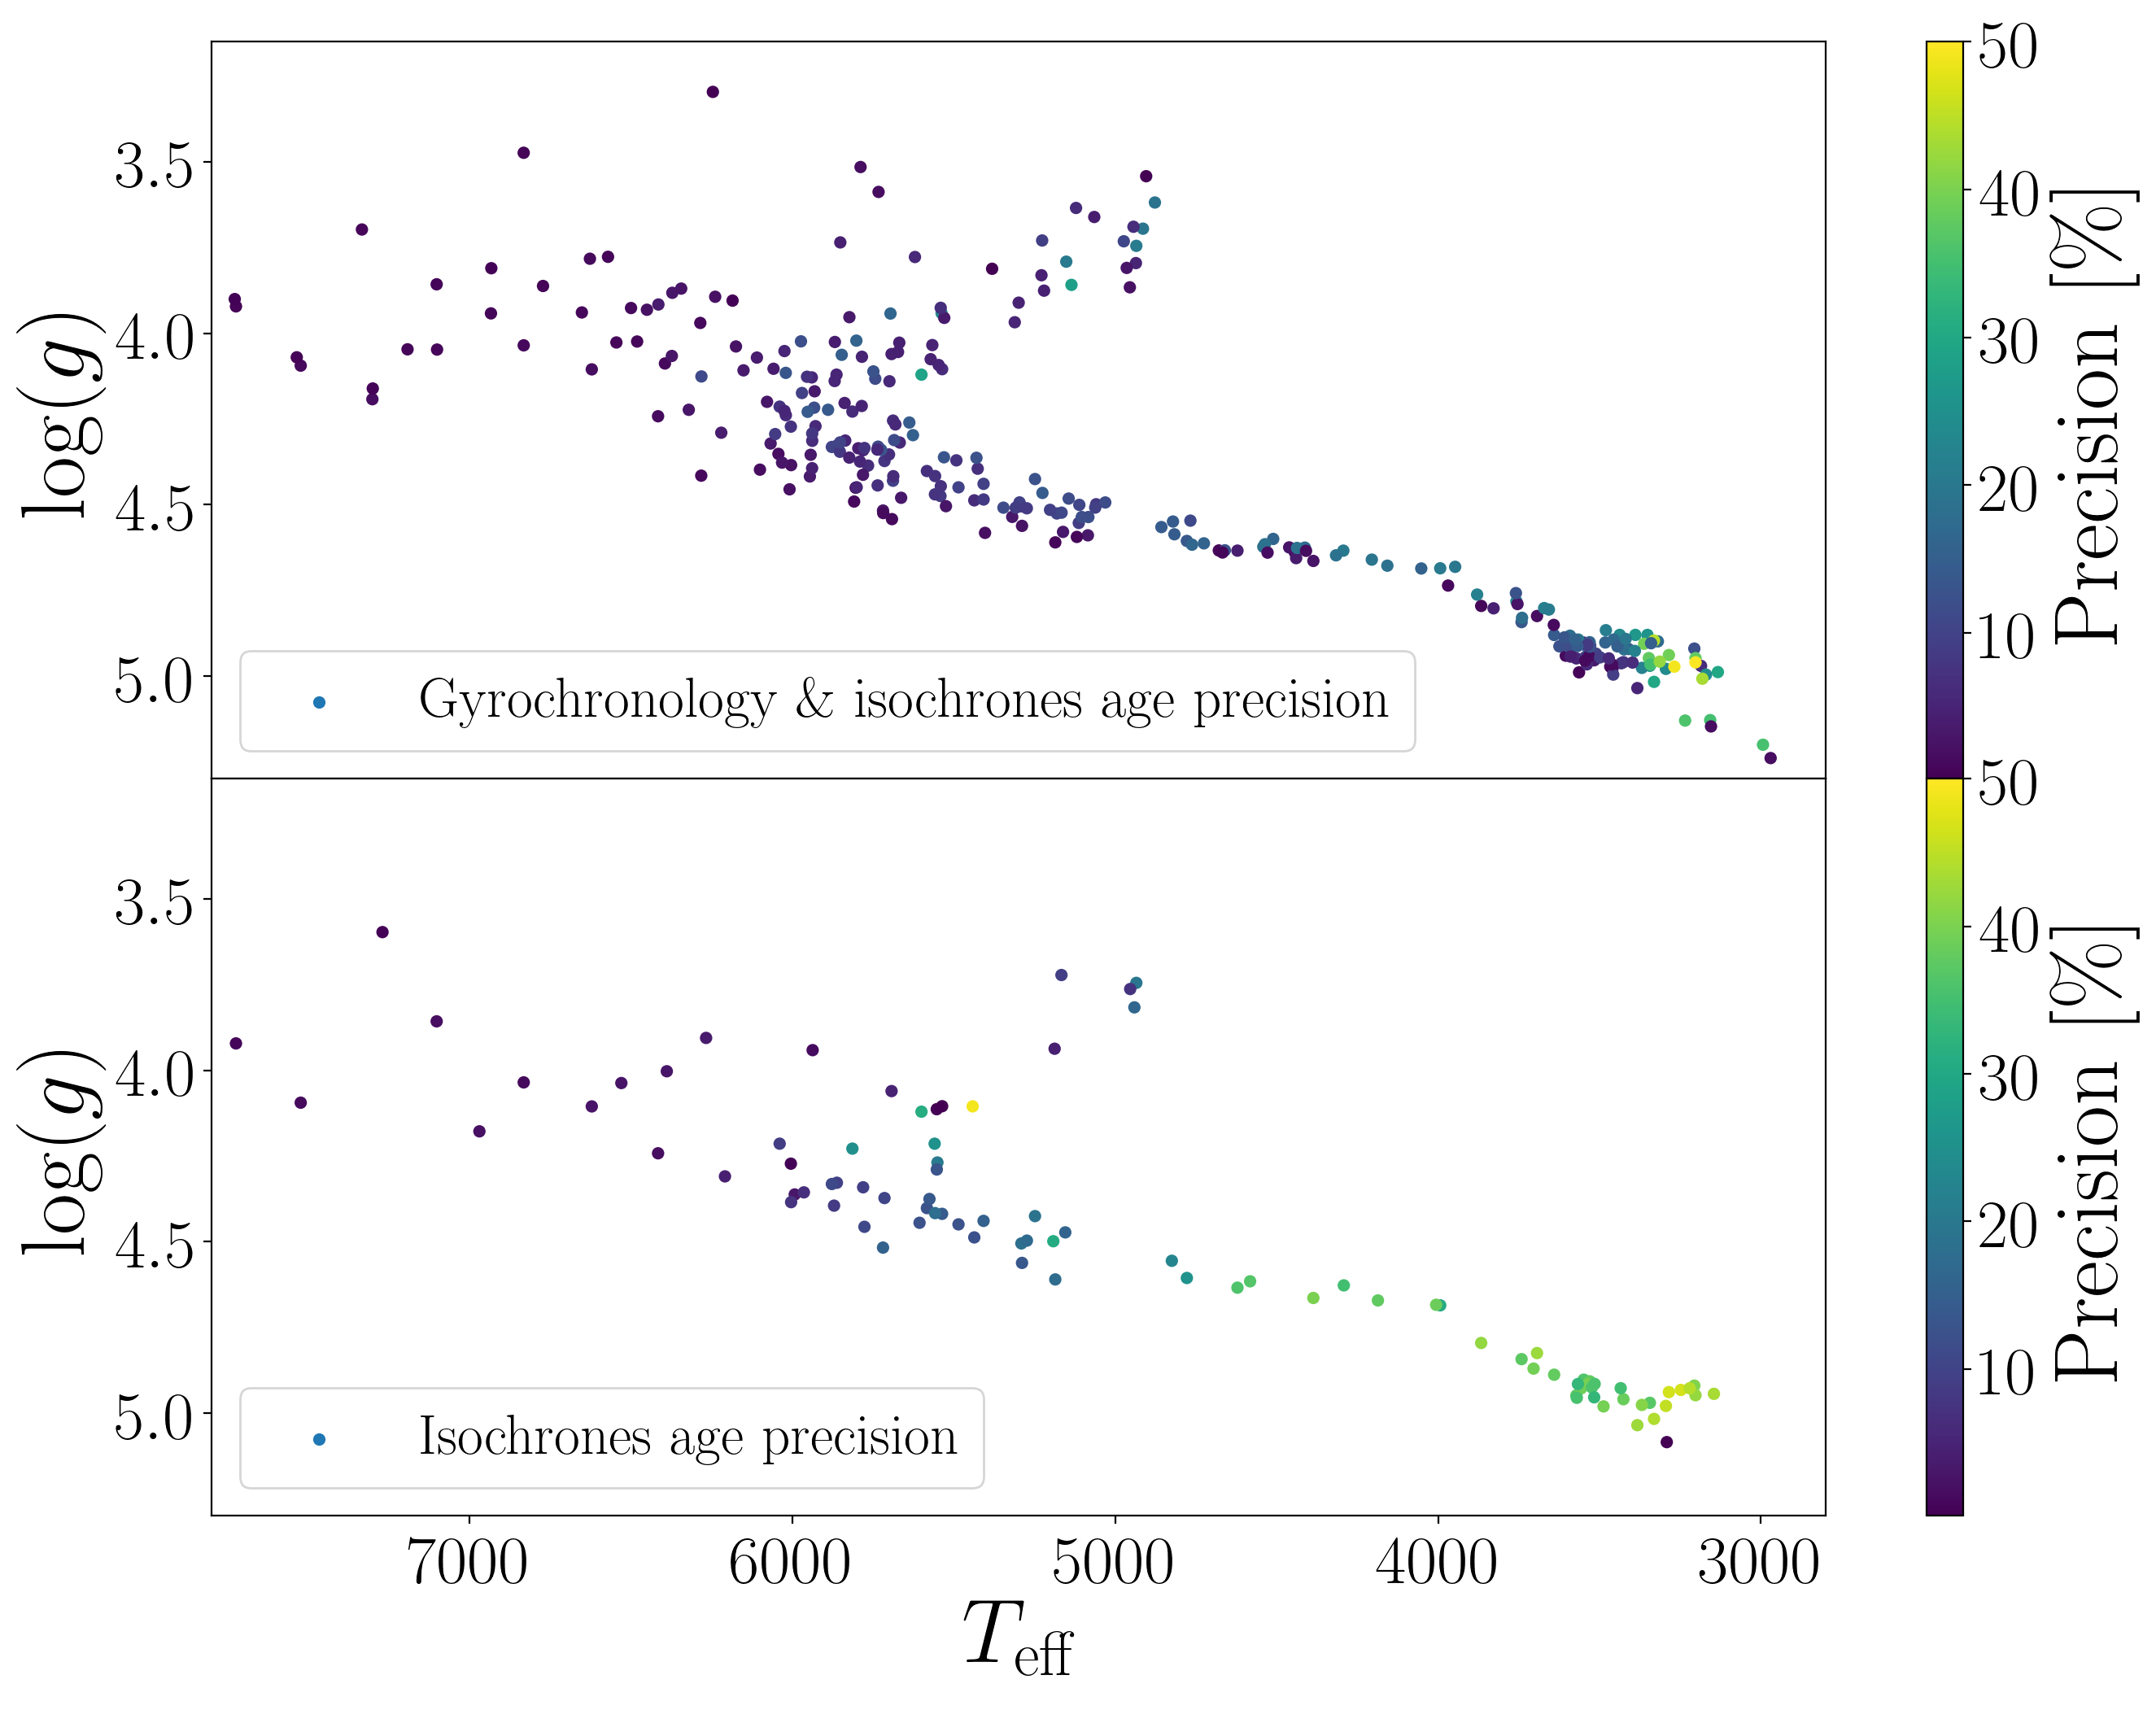

In [21]:
plotpar = {'axes.labelsize': 40,
           'font.size': 30,
           'legend.fontsize': 30,
           'xtick.labelsize': 30,
           'ytick.labelsize': 30,
           'text.usetex': True}
plt.rcParams.update(plotpar)

plotpar = {'legend.fontsize': 25}
plt.rcParams.update(plotpar)

plt.figure(figsize=(16, 12), dpi=200)
plt.subplot(2, 1, 1)
plt.scatter(df.teff.values[inds], df.logg.values[inds], 
            label="$\mathrm{Gyrochronology~\&~isochrones~age~precision}$",
            c=(std/df.age.values[inds])*100, s=20, vmax=50, rasterized=True)
plt.colorbar(label="$\mathrm{Precision~[\%]}$")
plt.xlim(7800, 2800)
plt.ylim(5.3, 3.15)
plt.xlabel("$T_{\mathrm{eff}}$")
plt.ylabel("$\log(g)$")
plt.legend(loc="lower left")

plt.subplot(2, 1, 2)
plt.scatter(df.teff.values[iinds], df.logg.values[iinds], label="$\mathrm{Isochrones~age~precision}$",
            c=(istd/df.age.values[iinds])*100, s=20, vmax=50, rasterized=True)
plt.colorbar(label="$\mathrm{Precision~[\%]}$")
plt.xlim(7800, 2800)
plt.ylim(5.3, 3.15)
plt.xlabel("$T_{\mathrm{eff}}$")
plt.ylabel("$\log(g)$")
plt.subplots_adjust(hspace=0)
plt.legend(loc="lower left")

# plt.savefig("../precision_plot.pdf")

Assign age value to be either the median age or the maximum-likelihood (ML) age depending on stellar color. We found that ML ages are overestimated for stars cooler than G_BP - G_RP = 1.3 but median ages look good. Median ages are underestimated for stars hotter than G_BP - G_RP = 1.3 but ML ages look good. This is because the isochrone likelihood function prefers cool stars to be extremely old (older than the age of the Universe) when there is little age information. Because of the uniform prior bounds on age this means that the ML value will be close to the age of the Universe. but the median value will be lower.

In [22]:
def age_from_ml_and_med(meds, ml, color, c_thresh=1.3):
    age = np.ones(len(meds)) * np.nan
    cool_mask = color > c_thresh
    age[cool_mask] = meds[cool_mask]
    age[~cool_mask] = ml[~cool_mask]
    return age

print(np.shape(meds))
age = age_from_ml_and_med(meds, ml, df.BP[inds] - df.RP[inds])
iage = age_from_ml_and_med(imeds, iml, df.BP[iinds] - df.RP[iinds])

(310,)


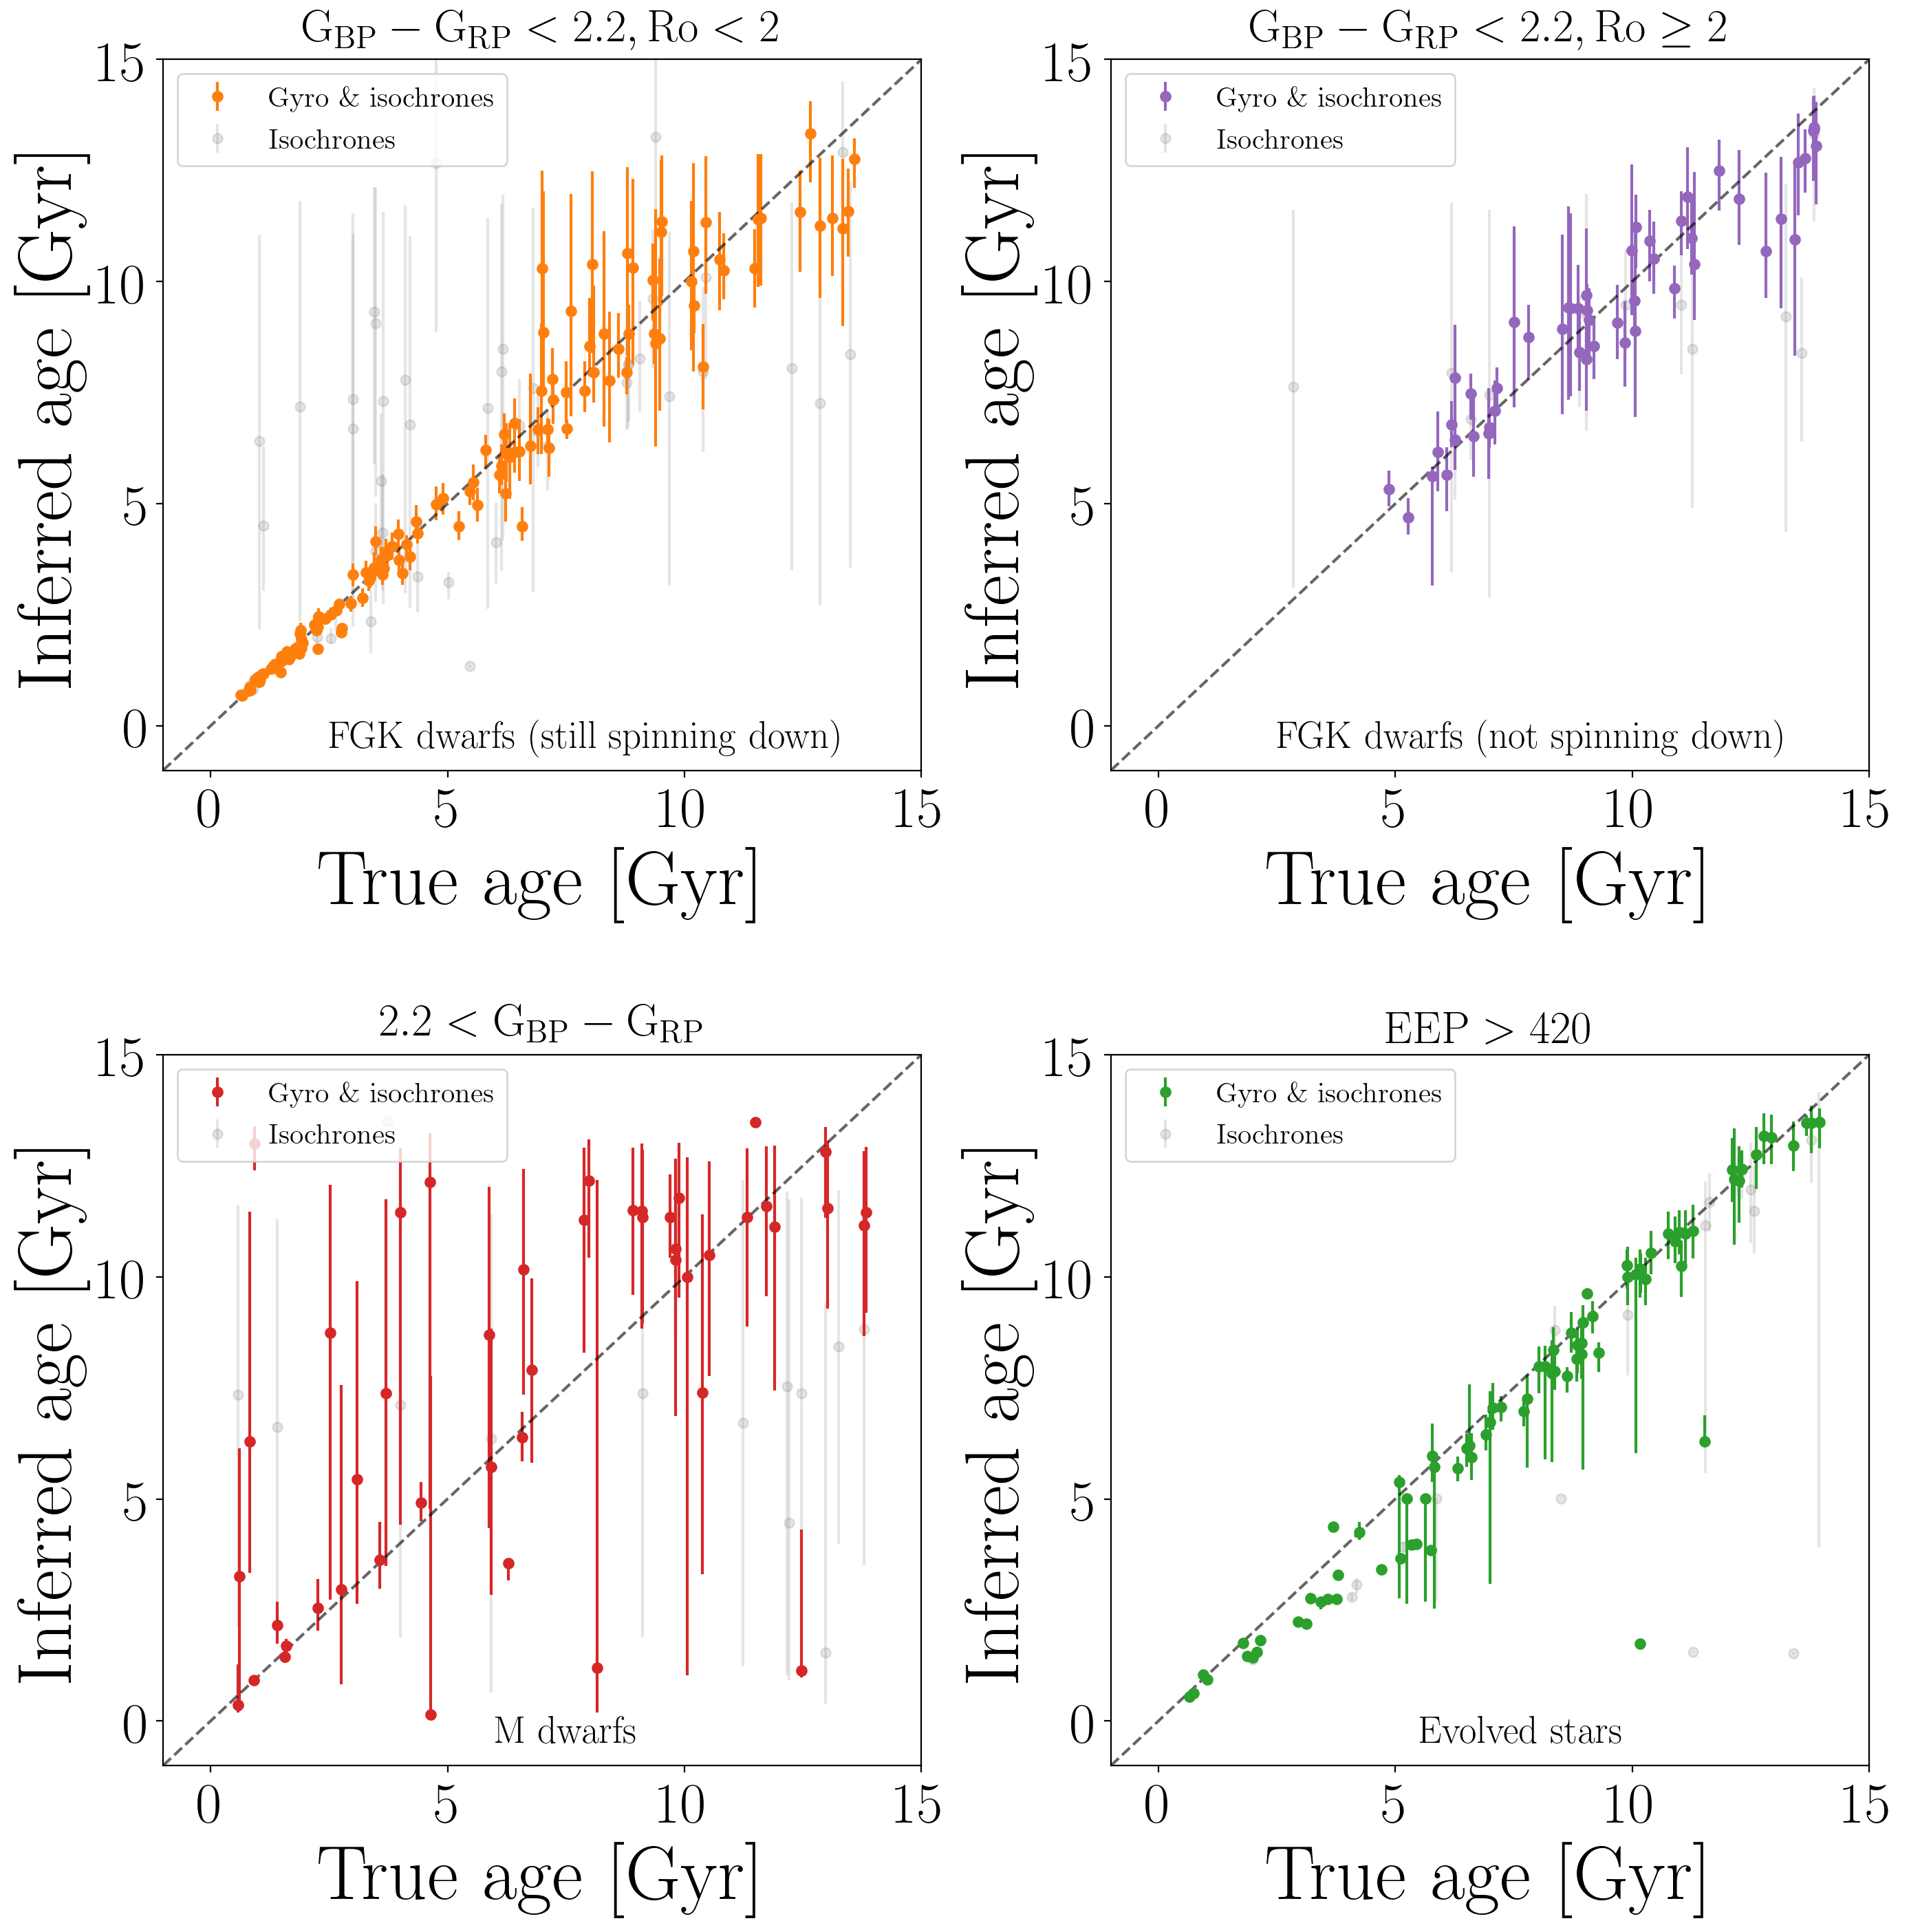

In [23]:
plotpar = {'legend.fontsize': 15,
           'font.size': 20}
plt.rcParams.update(plotpar)

plt.figure(figsize=(16, 26), dpi=200)

plt.subplot(3, 2, 1)
plt.errorbar(true_age_gyr[inds][fgk], age[fgk], yerr=[errm[fgk], errp[fgk]], fmt=".",
             ms=10, zorder=2, label="$\mathrm{Gyro~\&~isochrones}$",
             rasterized=True, color="tab:orange")
plt.errorbar(true_age_gyr[iinds][ifgk], iage[ifgk], yerr=[ierrm[ifgk], ierrp[ifgk]], fmt=".",
             ms=10, zorder=0, rasterized=True, color=".5", alpha=.2, label="$\mathrm{Isochrones}$")
plt.xlabel("$\mathrm{True~age~[Gyr]}$")
plt.ylabel("$\mathrm{Inferred~age~[Gyr]}$")
xs = np.linspace(-1, 16, 100)
plt.plot(xs, xs, "k", ls="--", alpha=.6)
plt.xlim(-1, 15)
plt.ylim(-1, 15)
plt.title("$\mathrm{G_{BP}-G_{RP} < 2.2, Ro < 2}$")
plt.legend(loc="upper left")
plt.text(2.5, -.5, "$\mathrm{FGK~dwarfs~(still~spinning~down)}$")

plt.subplot(3, 2, 2)
plt.errorbar(true_age_gyr[inds][rossbied], age[rossbied], yerr=[errm[rossbied], errp[rossbied]], fmt=".",
             ms=10, zorder=2, label="$\mathrm{Gyro~\&~isochrones}$", rasterized=True, color="tab:purple")
plt.errorbar(true_age_gyr[iinds][irossbied], iage[irossbied], yerr=[ierrm[irossbied], ierrp[irossbied]], fmt=".",
             ms=10, zorder=0, rasterized=True, color=".5", alpha=.2, label="$\mathrm{Isochrones}$")
plt.xlabel("$\mathrm{True~age~[Gyr]}$")
plt.ylabel("$\mathrm{Inferred~age~[Gyr]}$")
plt.plot(xs, xs, "k", ls="--", alpha=.6)
plt.xlim(-1, 15)
plt.ylim(-1, 15)
plt.title("$\mathrm{G_{BP}-G_{RP} < 2.2, Ro \geq 2}$")
plt.text(2.5, -.5, "$\mathrm{FGK~dwarfs~(not~spinning~down)}$")
plt.legend(loc="upper left")

# plt.subplot(3, 2, 3)
# plt.errorbar(true_age_gyr[inds][hot], age[hot], yerr=[errm[hot], errp[hot]], fmt=".",
#              color="tab:cyan", ms=10, zorder=2, label="$\mathrm{Gyro~\&~isochrones}$", rasterized=True)
# plt.errorbar(true_age_gyr[iinds][ihot], iage[ihot], yerr=[ierrm[ihot], ierrp[ihot]], fmt=".",
#              ms=10, zorder=0, rasterized=True, color=".5", alpha=.2, label="$\mathrm{Isochrones}$")
# plt.xlabel("$\mathrm{True~age~[Gyr]}$")
# plt.ylabel("$\mathrm{Inferred~age~[Gyr]}$")
# plt.plot(xs, xs, ".5", ls="--", alpha=.4)
# plt.xlim(-1, 15)
# plt.ylim(-1, 15)
# plt.title("$\mathrm{G_{BP} - G_{RP} < 0.56}$")
# plt.text(6, -.5, "$\mathrm{F~dwarfs}$")
# plt.legend(loc="upper left")

plt.subplot(3, 2, 3)
plt.errorbar(true_age_gyr[inds][cool], age[cool], yerr=[errm[cool], errp[cool]], fmt=".",
             color="tab:red", ms=10, zorder=2, label="$\mathrm{Gyro~\&~isochrones}$", rasterized=True)
plt.errorbar(true_age_gyr[iinds][icool], iage[icool], yerr=[ierrm[icool], ierrp[icool]], fmt=".",
             ms=10, zorder=0, rasterized=True, color=".5", alpha=.2, label="$\mathrm{Isochrones}$")
plt.xlabel("$\mathrm{True~age~[Gyr]}$")
plt.ylabel("$\mathrm{Inferred~age~[Gyr]}$")
plt.plot(xs, xs, "k", ls="--", alpha=.6)
plt.xlim(-1, 15)
plt.ylim(-1, 15)
plt.title("$\mathrm{2.2 < G_{BP} - G_{RP}}$")
plt.text(6, -.5, "$\mathrm{M~dwarfs}$")
plt.legend(loc="upper left")

plt.subplot(3, 2, 4)
plt.errorbar(true_age_gyr[inds][evolved], age[evolved], yerr=[errm[evolved], errp[evolved]], fmt=".",
             ms=10, zorder=2, label="$\mathrm{Gyro~\&~isochrones}$", rasterized=True, color="tab:green")
plt.errorbar(true_age_gyr[iinds][ievolved], iage[ievolved], yerr=[ierrm[ievolved], ierrp[ievolved]], fmt=".",
             ms=10, zorder=0, rasterized=True, color=".5", alpha=.2, label="$\mathrm{Isochrones}$")
plt.xlabel("$\mathrm{True~age~[Gyr]}$")
plt.ylabel("$\mathrm{Inferred~age~[Gyr]}$")
plt.plot(xs, xs, "k", ls="--", alpha=.6)
plt.xlim(-1, 15)
plt.ylim(-1, 15)
plt.title("$\mathrm{EEP > 420}$")
plt.text(5.5, -.5, "$\mathrm{Evolved~stars}$")
plt.legend(loc="upper left")

plt.subplots_adjust(wspace=.25, hspace=.4)
# plt.savefig("../simulation_results.pdf")
# plt.savefig("simulation_results")

1.707731763050822
3.6683820851876705


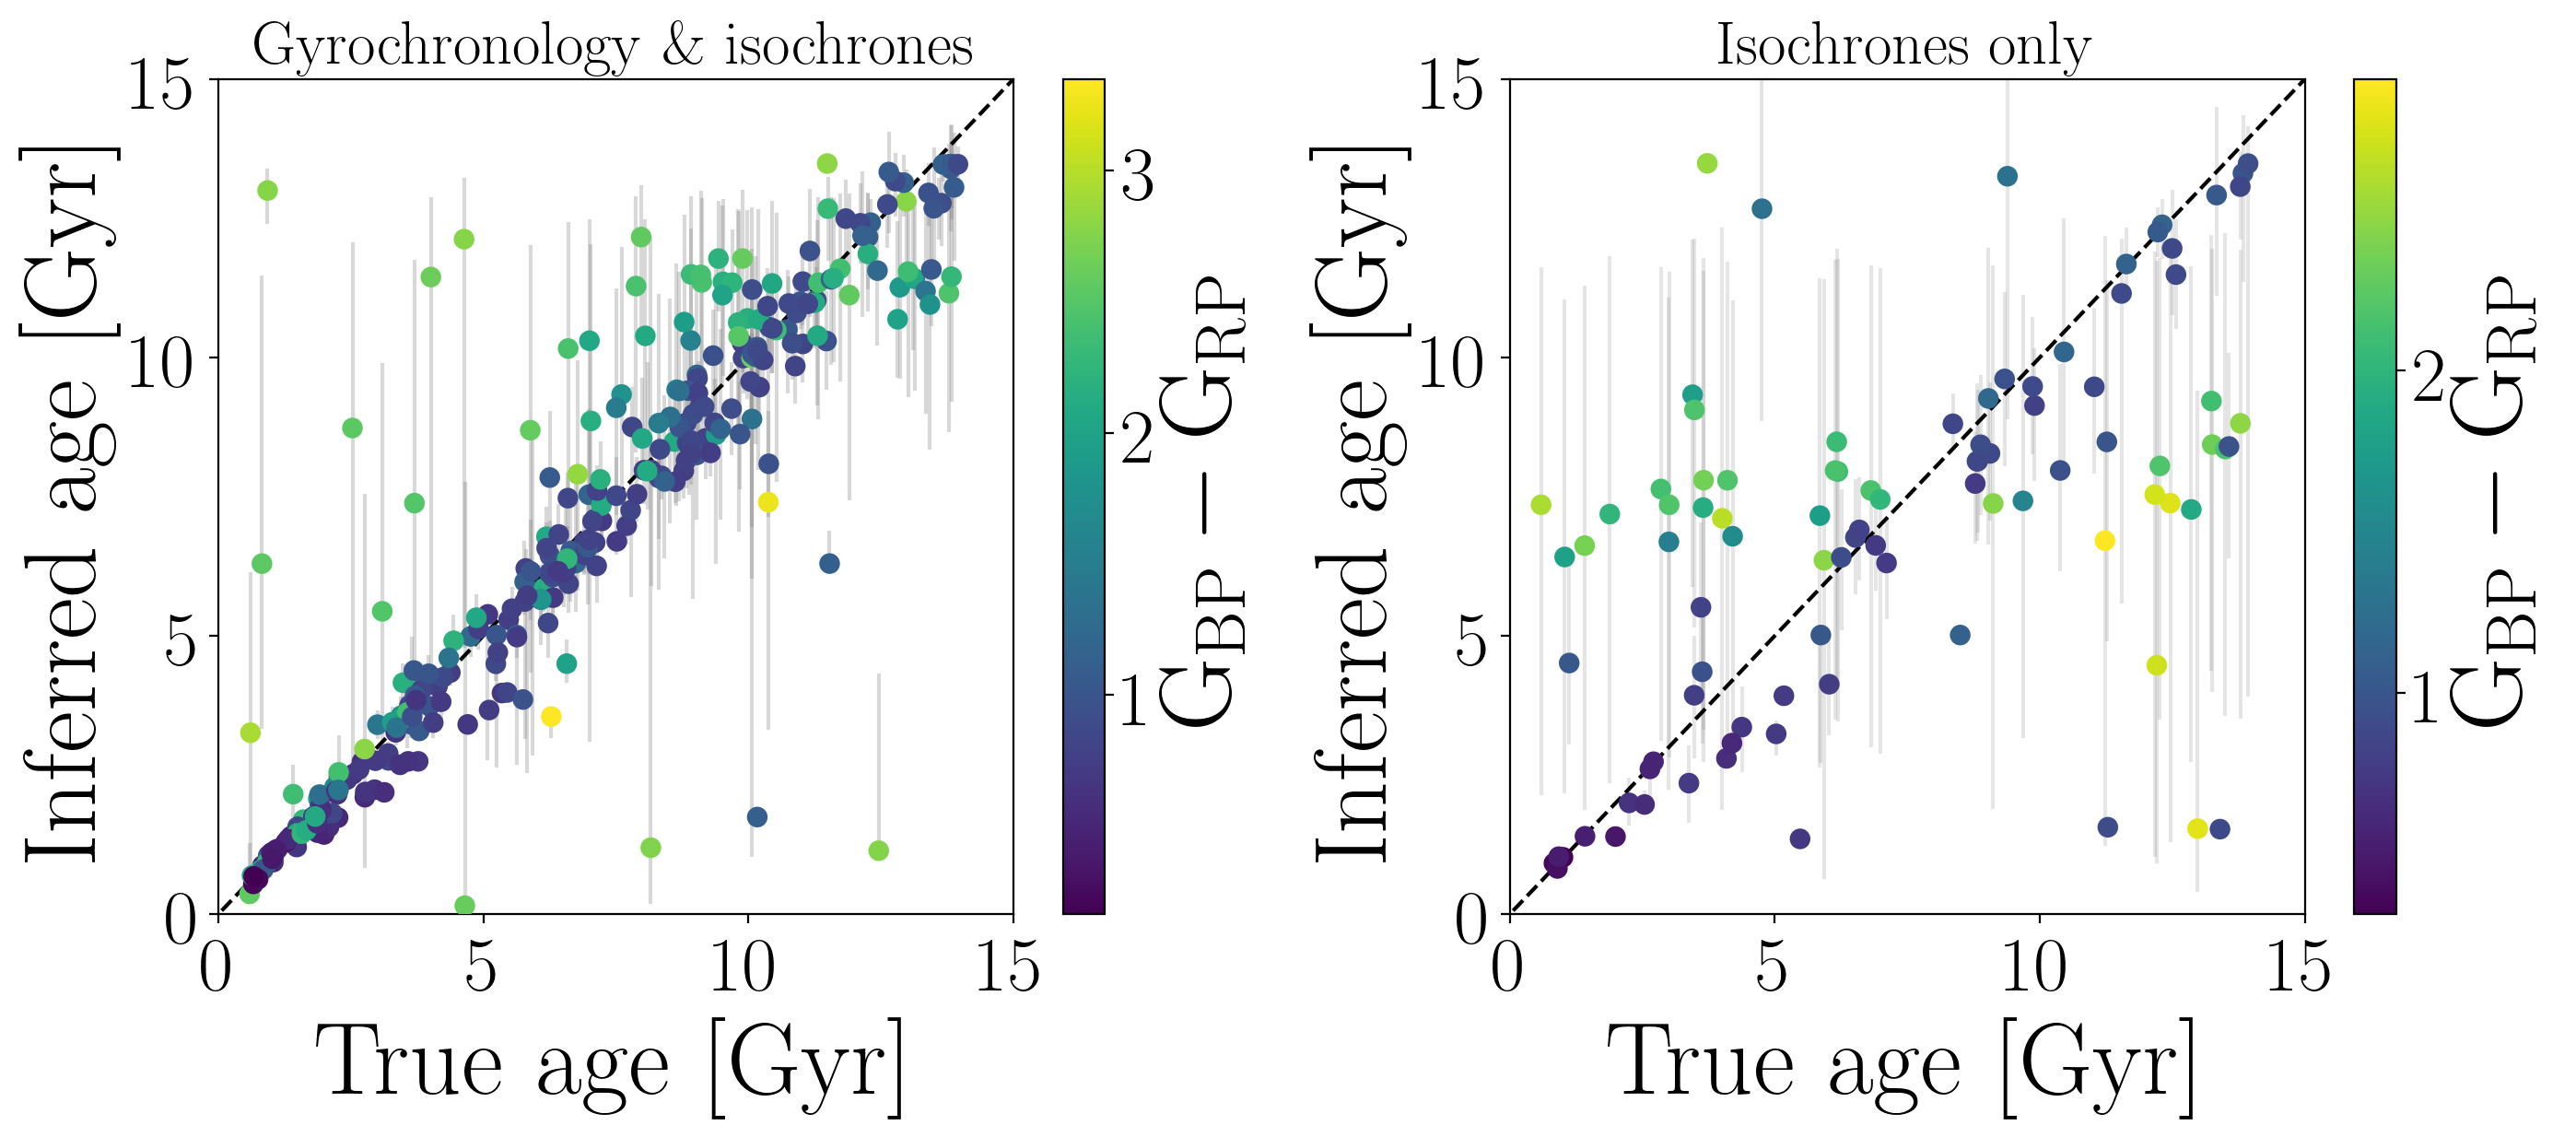

In [24]:
plotpar = {'legend.fontsize': 20}
plt.rcParams.update(plotpar)
plt.figure(figsize=(16, 6), dpi=200)

plt.subplot(1, 2, 1)
plt.scatter(true_age_gyr[inds], age, c=df.BP[inds] - df.RP[inds], s=50, zorder=3,
           rasterized=True)
plt.errorbar(true_age_gyr[inds], age, yerr=[errm, errp], fmt=".", color=".5", alpha=.3, zorder=0,
            rasterized=True)
plt.colorbar(label="$\mathrm{G_{BP} - G_{RP}}$")
plt.xlabel("$\mathrm{True~age~[Gyr]}$")
plt.ylabel("$\mathrm{Inferred~age~[Gyr]}$")
plt.plot(xs, xs, "k--", zorder=0, rasterized=True)
plt.xlim(0, 15)
plt.ylim(0, 15)
plt.title("$\mathrm{Gyrochronology~\&~isochrones}$")

plt.subplot(1, 2, 2)
plt.scatter(true_age_gyr[iinds], iage, c=df.BP[iinds] - df.RP[iinds], s=50, zorder=3,
           rasterized=True)
plt.errorbar(true_age_gyr[iinds], iage, yerr=[ierrm, ierrp], fmt=".", color=".5", alpha=.2, zorder=0,
            rasterized=True)
plt.plot(xs, xs, "k--", zorder=0)
plt.colorbar(label="$\mathrm{G_{BP} - G_{RP}}$")
plt.xlabel("$\mathrm{True~age~[Gyr]}$")
plt.ylabel("$\mathrm{Inferred~age~[Gyr]}$")
plt.xlim(0, 15)
plt.ylim(0, 15)
plt.title("$\mathrm{Isochrones~only}$")

plt.subplots_adjust(wspace=.3, hspace=.4)
plt.savefig("../all_iso_gyro.pdf")

def RMS(x, true):
    return np.sqrt(np.mean((x - true)**2))

print(RMS(true_age_gyr[inds], age))
print(RMS(true_age_gyr[iinds], iage))

20.74160638147227
28.308296519467888


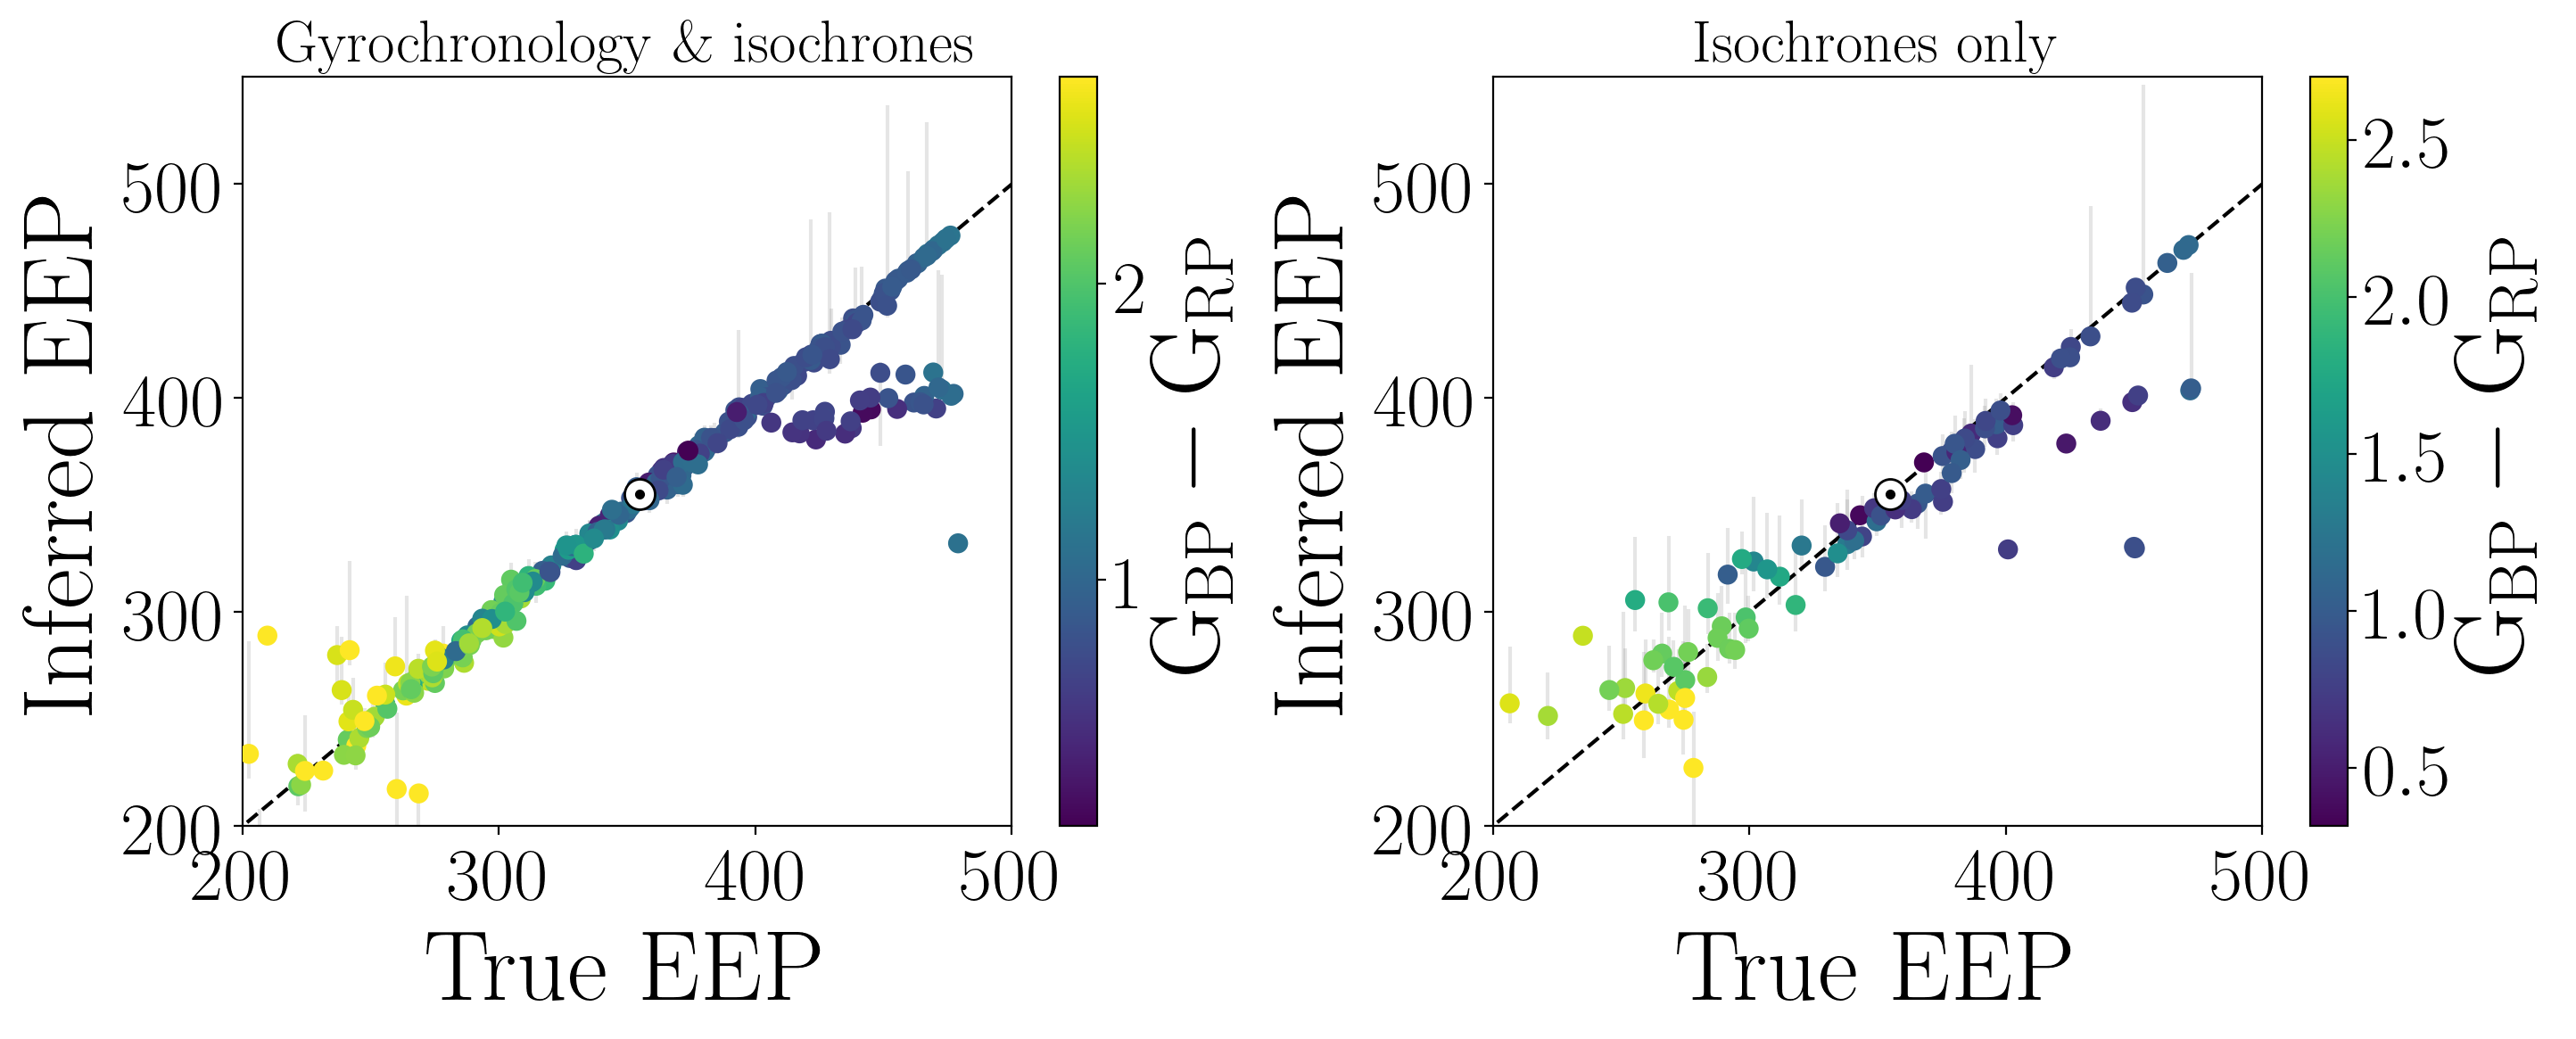

In [26]:
plt.figure(figsize=(16, 6), dpi=200)

xs = np.linspace(190, 500, 100)

plt.subplot(1, 2, 2)
plt.scatter(df.eep[iinds], ieeps, c=df.BP[iinds] - df.RP[iinds],
             s=50, zorder=3, vmin=min(df.BP[iinds]-df.RP[iinds]), vmax=2.7, rasterized=True)
plt.errorbar(df.eep[iinds], ieeps, yerr=[ieep_errp, ieep_errm], fmt=".", color=".5", alpha=.2, zorder=0,
            rasterized=True)
plt.plot(xs, xs, "k--", zorder=0)
plt.xlim(200, 500)
plt.ylim(200, 550)
plt.colorbar(label="$\mathrm{G_{BP}-G_{RP}}$")
plt.xlabel("$\mathrm{True~EEP}$")
plt.ylabel("$\mathrm{Inferred~EEP}$")
plt.title("$\mathrm{Isochrones~only}$")

plt.scatter(355, 355, facecolors='w', edgecolors="k", s=150, zorder=3, rasterized=True)
plt.plot(355, 355, "k.", zorder=3, rasterized=True)

# plt.plot(df.eep[iinds], ieeps, ".", color=".5", zorder=0)
plt.subplot(1, 2, 1)
plt.scatter(df.eep[inds], eeps, c=df.BP[inds] - df.RP[inds],
             s=50, zorder=3, vmin=min(df.BP[inds]-df.RP[inds]), vmax=2.7, rasterized=True)
plt.errorbar(df.eep[inds], eeps, yerr=[eep_errp, eep_errm], fmt=".", color=".5", alpha=.2, zorder=0,
            rasterized=True)
plt.plot(xs, xs, "k--", zorder=0)
plt.xlim(200, 500)
plt.ylim(200, 550)
plt.colorbar(label="$\mathrm{G_{BP}- G_{RP}}$")
plt.xlabel("$\mathrm{True~EEP}$")
plt.ylabel("$\mathrm{Inferred~EEP}$")
plt.title("$\mathrm{Gyrochronology~\&~isochrones}$")

plt.scatter(355, 355, facecolors='w', edgecolors="k", s=150, zorder=3, rasterized=True)
plt.plot(355, 355, "k.", zorder=3, rasterized=True)

plt.subplots_adjust(wspace=.3, bottom=.18)
plt.savefig("../eep.pdf")

print(RMS(eeps, df.eep[inds]))
print(RMS(ieeps, df.eep[iinds]))

Calculate precision changes.

In [499]:
def precision(stds, meds):
    return np.median(stds/meds)*100

def accuracy(true, meds):
    return np.median(abs(meds - true))*1e3

def rel_acc(true, meds):
    return np.median((abs(meds - true)/meds)*100)

print("median GK age precision = {:.2f} %".format(precision(std[fgk], age[fgk])))
print("GK RMS = {:.2f} Gyr".format(RMS(age[fgk], true_age_gyr[inds][fgk])))
print("median iso GK age precision = {:.2f} %".format(precision(istd[ifgk], iage[ifgk])))
print("GK iso RMS = {:.2f} Gyr".format(RMS(iage[ifgk], true_age_gyr[iinds][ifgk])))

print("\nmedian F age precision = {:.2f} %".format(precision(std[hot], age[hot])))
print("F RMS = {:.2f} Gyr".format(RMS(age[hot], true_age_gyr[inds][hot])))
print("median iso F age precision = {:.2f} %".format(precision(istd[ihot], iage[ihot])))
print("F iso RMS = {:.2f} Gyr".format(RMS(iage[ihot], true_age_gyr[iinds][ihot])))

print("\nmedian rossby age precision = {:.2f} %".format(precision(std[rossbied], age[rossbied])))
print("rossby RMS = {:.2f} Gyr".format(RMS(age[rossbied], true_age_gyr[inds][rossbied])))
print("median iso rossby age precision = {:.2f} %".format(precision(istd[irossbied], iage[irossbied])))
print("rossby iso RMS = {:.2f} Gyr".format(RMS(iage[irossbied], true_age_gyr[iinds][irossbied])))

print("\nmedian cool age precision = {:.2f} %".format(precision(std[cool], age[cool])))
print("cool RMS = {:.2f} Gyr".format(RMS(age[cool], true_age_gyr[inds][cool])))
print("median iso cool age precision = {:.2f} %".format(precision(istd[icool], iage[icool])))
print("cool iso RMS = {:.2f} Gyr".format(RMS(iage[icool], true_age_gyr[iinds][icool])))

print("\nmedian subgiant age precision = {:.2f} %".format(precision(std[evolved], age[evolved])))
print("evolved RMS = {:.2f} Gyr".format(RMS(age[evolved], true_age_gyr[inds][evolved])))
print("median iso subgiant age precision = {:.2f} %".format(precision(istd[ievolved], iage[ievolved])))
print("evolved iso RMS = {:.2f} Gyr".format(RMS(iage[ievolved], true_age_gyr[iinds][ievolved])))

print("\ntotal median age precision = {0}%".format(precision(std, age)))
print("total RMS = {:.2f} Gyr".format(RMS(age, true_age_gyr[inds])))
print("total iso median age precision = {0}%".format(precision(istd, iage)))
print("total iso RMS = {:.2f} Gyr".format(RMS(iage, true_age_gyr[iinds])))

median GK age precision = 10.82 %
GK RMS = 0.87 Gyr
median iso GK age precision = 32.06 %
GK iso RMS = 3.37 Gyr

median F age precision = 5.90 %
F RMS = 0.07 Gyr
median iso F age precision = 9.74 %
F iso RMS = 0.69 Gyr

median rossby age precision = 11.12 %
rossby RMS = 0.89 Gyr
median iso rossby age precision = 21.37 %
rossby iso RMS = 2.48 Gyr

median cool age precision = 25.45 %
cool RMS = 3.78 Gyr
median iso cool age precision = 55.89 %
cool iso RMS = 4.49 Gyr

median subgiant age precision = 10.90 %
evolved RMS = 1.40 Gyr
median iso subgiant age precision = 8.13 %
evolved iso RMS = 1.59 Gyr

total median age precision = 11.911047564887433%
total RMS = 1.76 Gyr
total iso median age precision = 28.73903089405328%
total iso RMS = 3.15 Gyr


Calculate precision for isochrone fitting.

In [225]:
print("median FGK age precision = {:.2f} %".format(precision(istd[ifgk], imeds[ifgk])))
print("FGK RMS = {:.2f} Gyr".format(RMS(imeds[ifgk], true_age_gyr[iinds][ifgk])))

print("\nmedian cool age precision = {:.2f} %".format(precision(istd[icool], imeds[icool])))
print("cool RMS = {:.2f} Gyr".format(RMS(imeds[icool], true_age_gyr[iinds][icool])))

print("\nmedian subgiant age precision = {:.2f} %".format(precision(istd[ievolved], imeds[ievolved])))
print("evolved RMS = {:.2f} Gyr".format(RMS(imeds[ievolved], true_age_gyr[iinds][ievolved])))

print("\ntotal median age precision = {0}%".format(precision(istd, imeds)))
print("total RMS = {:.2f} Gyr".format(RMS(imeds, true_age_gyr[iinds])))

median FGK age precision = 40.65 %
FGK RMS = 2.92 Gyr

median cool age precision = 55.89 %
cool RMS = 4.49 Gyr

median subgiant age precision = 8.06 %
evolved RMS = 2.35 Gyr

total median age precision = 28.380660165097854%
total RMS = 3.11 Gyr


Text(0.5, 0, 'log10(Rotation period [days])')

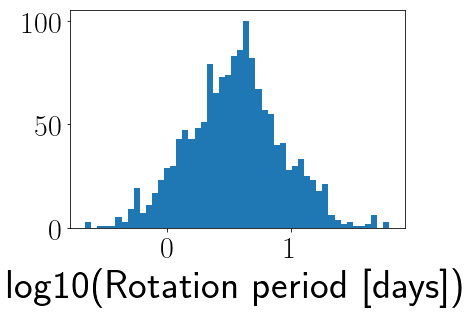

In [28]:
import pandas as pd
url = "https://arxiv.org/src/1402.5694v2/anc/Table_1_Periodic.txt"
mc = pd.read_csv(url)
plt.hist(np.log10(mc.Prot.values[mc.Teff.values > 6250]), 50);
plt.xlabel("log10(Rotation period [days])")

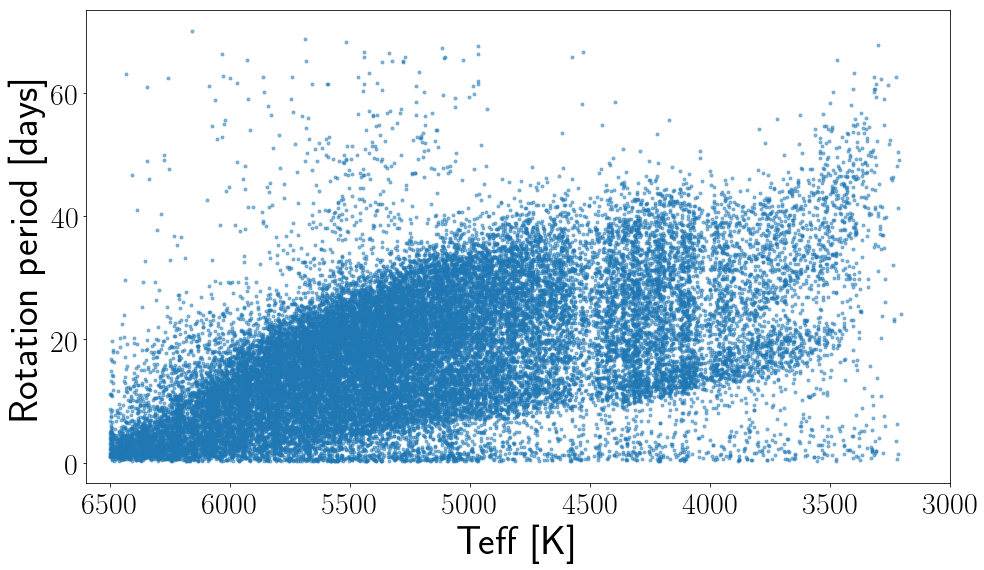

In [29]:
plt.figure(figsize=(16, 9))
plt.plot(mc.Teff, mc.Prot, ".", alpha=.5)
plt.xlim(6600, 3000)
plt.xlabel("Teff [K]")
plt.ylabel("Rotation period [days]")
plt.subplots_adjust(left=.15, bottom=.15)
plt.savefig("/Users/rangus/Desktop/period_teff")